In [3]:
import Cnn_tool.cnn_ana_py

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch

In [5]:
# 試行回数
trial_number = 1

## CNNを用いた$\pi^{0}$と$\gamma$のclassification(0.15m)

### 入力するDataSetの読み込みと処理

In [6]:
#read Dataset
ds_gammax = np.load("./gamma_20GeV/xhitmap.npy")
ds_gammay = np.load("./gamma_20GeV/yhitmap.npy")
ds_gammaz = np.load("./gamma_20GeV/zhitmap.npy")

ds_pi0x = np.load("./pi0_20GeV/xhitmap.npy")
ds_pi0y = np.load("./pi0_20GeV/yhitmap.npy")
ds_pi0z = np.load("./pi0_20GeV/zhitmap.npy")

In [7]:
# create label
# Backgraund = gamma, Signal = pi0
b = np.full(500, 0)
s = np.full(500, 1)
event_number = np.arange(1000)
print(b, s, event_number)

[0 0 0 ... 0 0 0] [1 1 1 ... 1 1 1] [    0     1     2 ... 19997 19998 19999]


In [8]:
# image stack
ds_gamma_c3 = np.stack([ds_gammax, ds_gammay, ds_gammaz], 0).transpose(1, 2, 3, 0)
ds_pi0_c3 = np.stack([ds_pi0x, ds_pi0y, ds_pi0z], 0).transpose(1, 2, 3, 0)
print(ds_gamma_c3.shape, ds_pi0_c3.shape)

(10000, 100, 100, 3) (10000, 100, 100, 3)


In [10]:
# create x_dataset
x_c1 = np.concatenate([ds_gammax, ds_pi0x])
x_c1 = x_c1[:, np.newaxis, :, :]
x_c3 = np.concatenate([ds_gamma_c3, ds_pi0_c3])
x_c3 = x_c3.transpose(0, 3, 1, 2)

#y_datasetの作成
y = np.concatenate([b, s])

print(x_c1.shape, x_c3.shape, y.shape, event_number.shape)

(20000, 1, 100, 100) (20000, 3, 100, 100) (20000,) (20000,)


In [11]:
#datasetをtrain, valid, testに分割する
tv_t_seed_c1 = np.random.randint(1, 10000)
tv_t_seed_c3 = np.random.randint(1, 10000)
x_c1_train_valid, x_c1_test, y_c1_train_valid, y_c1_test, en_c1_train_valid, en_c1_test = train_test_split(x_c1, y, event_number, train_size=0.8, random_state=tv_t_seed_c1)
x_c3_train_valid, x_c3_test, y_c3_train_valid, y_c3_test, en_c3_train_valid, en_c3_test = train_test_split(x_c3, y, event_number, train_size=0.8, random_state=tv_t_seed_c3)

t_v_seed_c1 = np.random.randint(1, 10000)
t_v_seed_c3 = np.random.randint(1, 10000)
x_c1_train, x_c1_valid, y_c1_train, y_c1_valid, en_c1_train, en_c1_valid = train_test_split(x_c1_train_valid, y_c1_train_valid, en_c1_train_valid, train_size=0.75, random_state=t_v_seed_c1)
x_c3_train, x_c3_valid, y_c3_train, y_c3_valid, en_c3_train, en_c3_valid = train_test_split(x_c3_train_valid, y_c3_train_valid, en_c3_train_valid, train_size=0.75, random_state=t_v_seed_c3)
print("Train_Valid and Test split seed number:", tv_t_seed_c1, tv_t_seed_c3)
print("Train and Valid split seed number:", t_v_seed_c1, t_v_seed_c3)
print(x_c1_train.shape, x_c1_valid.shape, x_c1_test.shape)
print(x_c3_train.shape, x_c3_valid.shape, x_c3_test.shape)

Train_Valid and Test split seed number: 3685 7857
Train and Valid split seed number: 8274 6296
(12000, 1, 100, 100) (4000, 1, 100, 100) (4000, 1, 100, 100)
(12000, 3, 100, 100) (4000, 3, 100, 100) (4000, 3, 100, 100)


### TorchTensol, DataLoaderへの変換

In [12]:
# import
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch import tensor, float32

In [13]:

train_c1 = TensorDataset(tensor(x_c1_train, dtype=float32), tensor(y_c1_train[:, np.newaxis], dtype=float32))
valid_c1 = TensorDataset(tensor(x_c1_valid, dtype=float32), tensor(y_c1_valid[:, np.newaxis], dtype=float32))
test_c1 = TensorDataset(tensor(x_c1_test, dtype=float32), tensor(y_c1_test[:, np.newaxis], dtype=float32))

train_c3 = TensorDataset(tensor(x_c3_train).float(), tensor(y_c3_train[:, np.newaxis]).float())
valid_c3 = TensorDataset(tensor(x_c3_valid).float(), tensor(y_c3_valid[:, np.newaxis]).float())
test_c3 = TensorDataset(tensor(x_c3_test).float(), tensor(y_c3_test[:, np.newaxis]).float())

In [14]:
#DataLoader
batch_size = 128
train_c1_dataloader = DataLoader(train_c1, batch_size=batch_size, shuffle=True)
valid_c1_dataloader = DataLoader(valid_c1, batch_size=batch_size, shuffle=True)
test_c1_dataloader = DataLoader(test_c1, batch_size=batch_size, shuffle=False)

train_c3_dataloader = DataLoader(train_c3, batch_size=batch_size, shuffle=True)
test_c3_dataloader = DataLoader(test_c3, batch_size=batch_size, shuffle=False)
valid_c3_dataloader = DataLoader(valid_c3, batch_size=batch_size, shuffle=True)

### modelの定義

In [15]:
import torch.nn as nn
from torch.nn import Sequential, Flatten, Conv2d, MaxPool2d, Linear, ReLU, Sigmoid

class ConvNet(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.conv_relu_stack = Sequential(
            Conv2d(input_shape, 64, 3), # output_channels=64, karnel_size=3
            Conv2d(64, 64, 3), # input_channels=64, output_channels=64, karnel_size=3
            MaxPool2d(2, 2), # karnel_size=2, stride=2
            ReLU(),
            Conv2d(64, 32, 3), # input_channels=64, output_channels=32, karnel_size=3
            Conv2d(32, 32, 3), # input_channels=32, output_channels=32, karnel_size=3
            MaxPool2d(2, 2), # karnel_size=2, stride=2
            ReLU()
        ) # input:W=H=100, C output:W=H=22, C=32
        self.linear_relu_stack = Sequential(
            Flatten(),
            Linear(32*22*22, 128), #input=32*22*22, output=128
            ReLU(),
            Linear(128, 1), #input=128, output=1
            Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv_relu_stack(x)
        x = self.linear_relu_stack(x)
        return x

In [16]:
#trainingの時とtestの時にmodelを動かすための関数

def train(dataloader, model, loss_fn, optimizer):
    # modelをtrain modelに切り替える
    model.train()
    # 1 epochでのlossの合計を入力する変数
    train_loss_total = 0.
    for x, y in dataloader:
        x, y = x.to("cuda"), y.to("cuda")
        # 順伝播
        y_pred = model(x)
        # loss function
        loss = loss_fn(y_pred, y)
        train_loss_total += loss
        # back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # loss average
    train_loss = train_loss_total/len(dataloader)
    return train_loss

def valid(dataloader, model, loss_fn, threshold=0.5):
    # modelをevaluation modeに切り替える
    model.eval()
    # 1 epochでのlossの合計を入力する変数
    valid_loss_total = 0.
    # anserとyが一致した回数を入力する変数
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to("cuda"), y.to("cuda")
            # 順伝播
            y_pred = model(x)
            # loss function
            loss = loss_fn(y_pred, y)
            valid_loss_total += loss
            # accuracyを計算するためのthreshold
            np_threshold = np.full(y.shape[0],threshold)
            tensor_threshold = tensor(np_threshold[:, np.newaxis], dtype=float32).to("cuda")
            # anserとyが一致した回数
            anser = (y_pred>=tensor_threshold).type(float32)
            correct += (anser==y).type(float32).sum().item()
    # loss average
    valid_loss = valid_loss_total/len(dataloader)
    # accuracy
    correct /= len(dataloader.dataset)
    return valid_loss, correct

In [17]:
def test(dataloader, model):
    # modelをevaluation modeに切り替える
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x, y = x.to("cuda"), y.to("cuda")
            # 順伝播
            y_pred = model(x)
            # print(y_pred.size(), y.size())
            np_y_pred = y_pred.to("cpu").detach().numpy()
            np_y = y.to("cpu").detach().numpy()
            if i==0:
                output = np_y_pred
                true = np_y
            else:
                output = np.concatenate([output, np_y_pred], axis=0)
                true = np.concatenate([true, np_y], axis=0)
    # output = np.array(output)
    # true = np.array(true)
    return output, true

### 学習

### input channel = 1

In [18]:
# loss_function = BCEloss, optimizer = Adam
from torch.nn import BCELoss
from torch.optim import Adam

# model instance
# input_shape:batch_size=64, channels=1, W=H=100
model_c1 = ConvNet(1).to("cuda")

loss_fn = BCELoss()
optimizer = Adam(model_c1.parameters())
# epochごとのlossを入力するリスト
tloss = []
vloss = []
# epochごとのaccuracyを入力するリスト
taccuracy = []
vaccuracy = []

# training
num_epoch = 10
for i_epoch in range(num_epoch):
    #train
    train_loss = train(train_c1_dataloader, model_c1, loss_fn, optimizer)
    _, train_accuracy = valid(train_c1_dataloader, model_c1, loss_fn) 
    tloss.append(train_loss.to("cpu").detach().numpy())
    taccuracy.append(train_accuracy)
    #validation
    valid_loss, valid_accuracy = valid(valid_c1_dataloader, model_c1, loss_fn)
    vloss.append(valid_loss.to("cpu").detach().numpy())
    vaccuracy.append(valid_accuracy)

    print(f"Train loss: {train_loss:.5f}, Train accuraxy: {train_accuracy:.5f}, Validation loss: {valid_loss:.5f}, Validation accuracy: {valid_accuracy:.5f}")

tloss = np.array(tloss)
taccuracy = np.array(taccuracy)
vloss = np.array(vloss)
vaccuracy = np.array(vaccuracy)

Train loss: 0.64637, Train accuraxy: 0.68417, Validation loss: 0.59086, Validation accuracy: 0.68050
Train loss: 0.57680, Train accuraxy: 0.71542, Validation loss: 0.54771, Validation accuracy: 0.71600
Train loss: 0.54290, Train accuraxy: 0.72250, Validation loss: 0.54123, Validation accuracy: 0.71000
Train loss: 0.53032, Train accuraxy: 0.73250, Validation loss: 0.52672, Validation accuracy: 0.72400
Train loss: 0.51866, Train accuraxy: 0.74167, Validation loss: 0.52226, Validation accuracy: 0.73025
Train loss: 0.51115, Train accuraxy: 0.72450, Validation loss: 0.53751, Validation accuracy: 0.70100
Train loss: 0.50672, Train accuraxy: 0.75817, Validation loss: 0.50607, Validation accuracy: 0.74375
Train loss: 0.49902, Train accuraxy: 0.75925, Validation loss: 0.50361, Validation accuracy: 0.73600
Train loss: 0.49455, Train accuraxy: 0.77092, Validation loss: 0.50169, Validation accuracy: 0.74525
Train loss: 0.48836, Train accuraxy: 0.74658, Validation loss: 0.53622, Validation accuracy

In [19]:
#　パラメータの保存
torch.save(model_c1.state_dict(), f"./CNNparameter/imput1channel{trial_number}")

評価

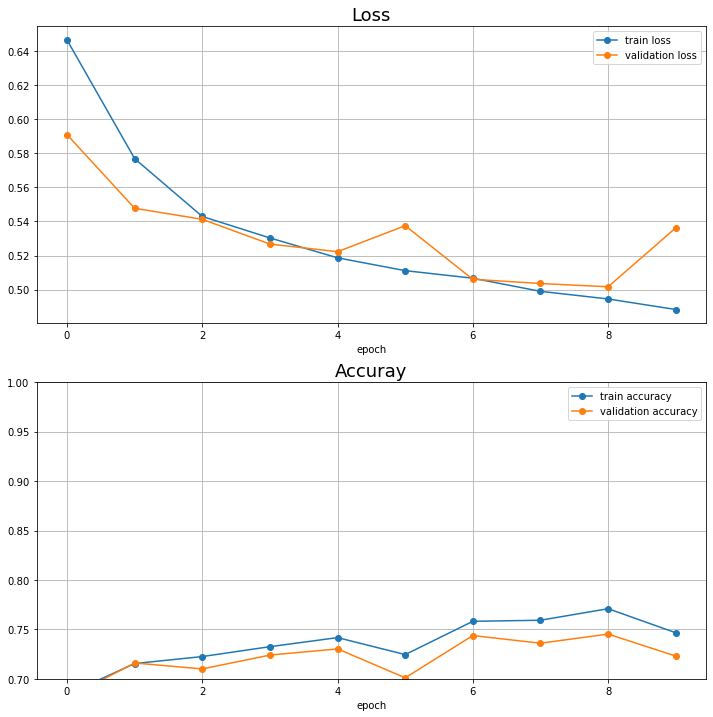

In [20]:
Cnn_tool.plot_loss_accuracy(tloss, vloss, taccuracy, vaccuracy)

In [22]:
np.save(f"./c1test_result/tloss{trial_number}", tloss)
np.save(f"./c1test_result/vloss{trial_number}", vloss)
np.save(f"./c1test_result/taccuracy{trial_number}", taccuracy)
np.save(f"./c1test_result/vaccuracy{trial_number}", vaccuracy)

In [23]:
output_y, true_y = test(test_c1_dataloader, model_c1)
output_y = output_y.reshape([4000])
true_y = true_y.reshape([4000])
print(output_y.shape, type(output_y))
print(true_y.shape, type(true_y))
output_y
print(Cnn_tool.test_accuracy(output_y, true_y))

(4000,) <class 'numpy.ndarray'>
(4000,) <class 'numpy.ndarray'>
0.72175


(2, 4000)
(2, 1953) (2, 2047)


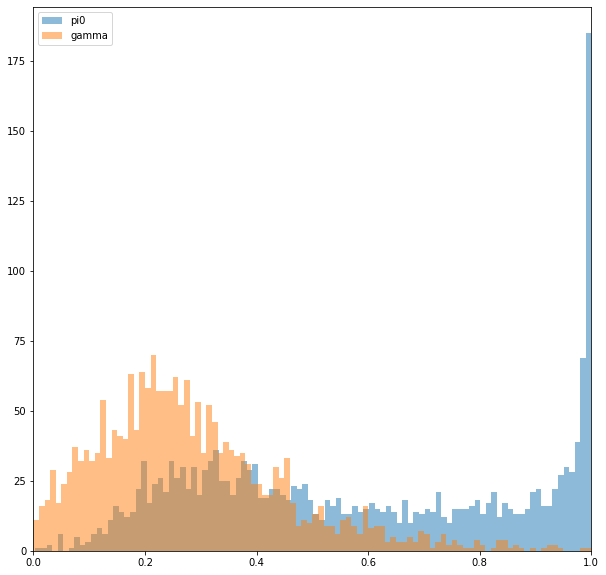

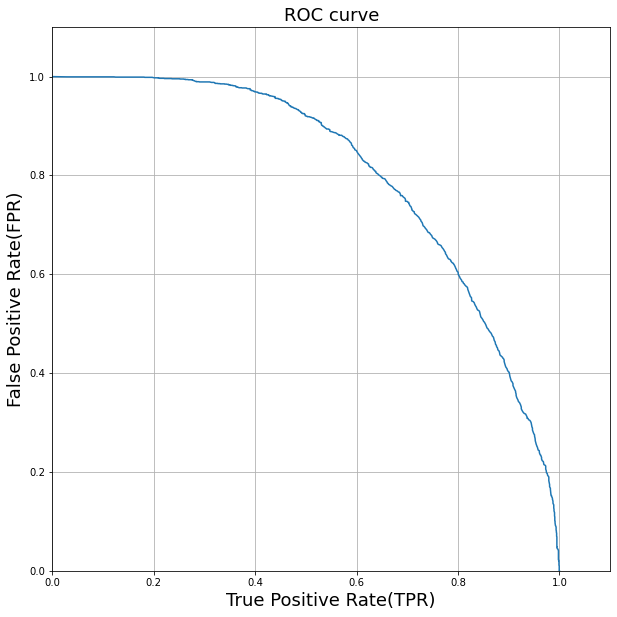

In [24]:
Cnn_tool.sb_histgram(output_y, true_y)
Cnn_tool.plot_roc(output_y, true_y)

In [25]:
x_c1_test.shape
np.save(f"./c1test_result/x{trial_number}", x_c1_test)
np.save(f"./c1test_result/y_output{trial_number}", output_y)
np.save(f"./c1test_result/y_label{trial_number}", true_y)
np.save(f"./c1test_result/event_number{trial_number}", en_c1_test)

### input channel = 3

In [26]:
# loss_function = BCEloss, optimizer = Adam
from torch.nn import BCELoss
from torch.optim import Adam

# model instance
# input_shape:batch_size=64, channels=1, W=H=100
model_c3 = ConvNet(3).to("cuda")

loss_fn = BCELoss()
optimizer_c3 = Adam(model_c3.parameters())
# epochごとのlossを入力するリスト
tloss_c3 = []
vloss_c3 = []
# epochごとのaccuracyを入力するリスト
taccuracy_c3 = []
vaccuracy_c3 = []

# training
num_epoch = 10
for i_epoch in range(num_epoch):
    #train
    train_loss = train(train_c3_dataloader, model_c3, loss_fn, optimizer_c3)
    _, train_accuracy = valid(train_c3_dataloader, model_c3, loss_fn) 
    tloss_c3.append(train_loss.to("cpu").detach().numpy())
    taccuracy_c3.append(train_accuracy)
    #validation
    valid_loss, valid_accuracy = valid(valid_c3_dataloader, model_c3, loss_fn)
    vloss_c3.append(valid_loss.to("cpu").detach().numpy())
    vaccuracy_c3.append(valid_accuracy)

    print(f"Train loss: {train_loss:.5f}, Train accuraxy: {train_accuracy:.5f}, Validation loss: {valid_loss:.5f}, Validation accuracy: {valid_accuracy:.5f}")

tloss_c3 = np.array(tloss_c3)
taccuracy_c3 = np.array(taccuracy_c3)
vloss_c3 = np.array(vloss_c3)
vaccuracy_c3 = np.array(vaccuracy_c3)

Train loss: 0.37500, Train accuraxy: 0.87017, Validation loss: 0.31102, Validation accuracy: 0.86950
Train loss: 0.28207, Train accuraxy: 0.89833, Validation loss: 0.27416, Validation accuracy: 0.88650
Train loss: 0.27981, Train accuraxy: 0.89675, Validation loss: 0.27500, Validation accuracy: 0.88800
Train loss: 0.25497, Train accuraxy: 0.89042, Validation loss: 0.27862, Validation accuracy: 0.88700
Train loss: 0.25890, Train accuraxy: 0.90092, Validation loss: 0.26765, Validation accuracy: 0.89500
Train loss: 0.23894, Train accuraxy: 0.89808, Validation loss: 0.28740, Validation accuracy: 0.88825
Train loss: 0.23394, Train accuraxy: 0.91275, Validation loss: 0.25702, Validation accuracy: 0.89775
Train loss: 0.23326, Train accuraxy: 0.91517, Validation loss: 0.25357, Validation accuracy: 0.90100
Train loss: 0.22343, Train accuraxy: 0.91467, Validation loss: 0.25570, Validation accuracy: 0.90175
Train loss: 0.20904, Train accuraxy: 0.92533, Validation loss: 0.24339, Validation accuracy

In [27]:
#　パラメータの保存
torch.save(model_c3.state_dict(), f"./CNNparameter/imput3channel{trial_number}")

評価

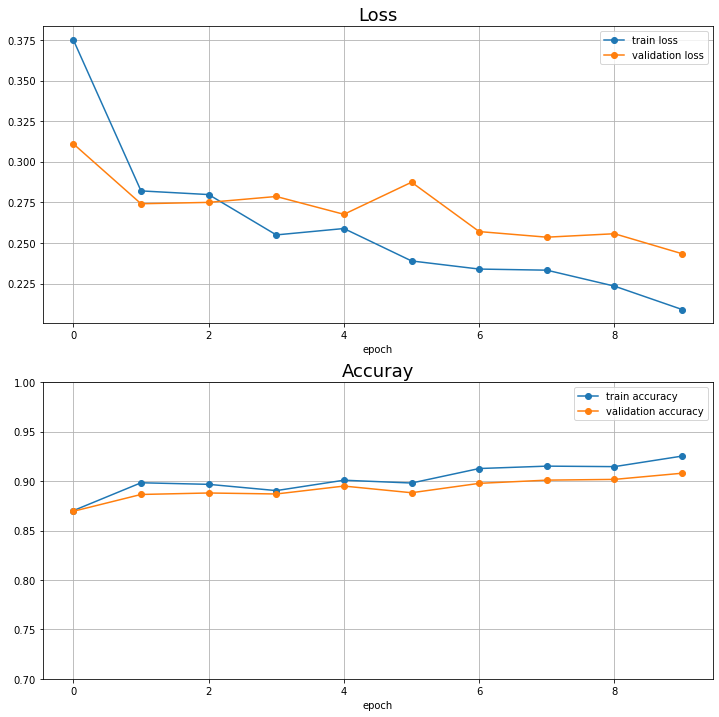

In [28]:
Cnn_tool.plot_loss_accuracy(tloss_c3, vloss_c3, taccuracy_c3, vaccuracy_c3)

In [29]:
np.save(f"./c3test_result/tloss{trial_number}", tloss_c3)
np.save(f"./c3test_result/vloss{trial_number}", vloss_c3)
np.save(f"./c3test_result/taccuracy{trial_number}", taccuracy_c3)
np.save(f"./c3test_result/vaccuracy{trial_number}", vaccuracy_c3)

In [30]:
output_y_c3, true_y_c3 = test(test_c3_dataloader, model_c3)
output_y_c3 = output_y_c3.reshape([4000])
true_y_c3 = true_y_c3.reshape([4000])
print(output_y_c3.shape, type(output_y_c3))
print(true_y_c3.shape, type(true_y_c3))
output_y_c3
print(Cnn_tool.test_accuracy(output_y_c3, true_y_c3))

(4000,) <class 'numpy.ndarray'>
(4000,) <class 'numpy.ndarray'>
0.90075


(2, 4000)
(2, 1985) (2, 2015)


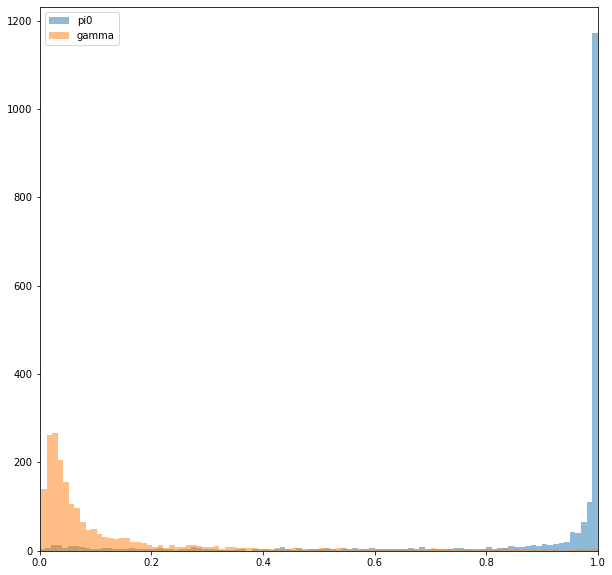

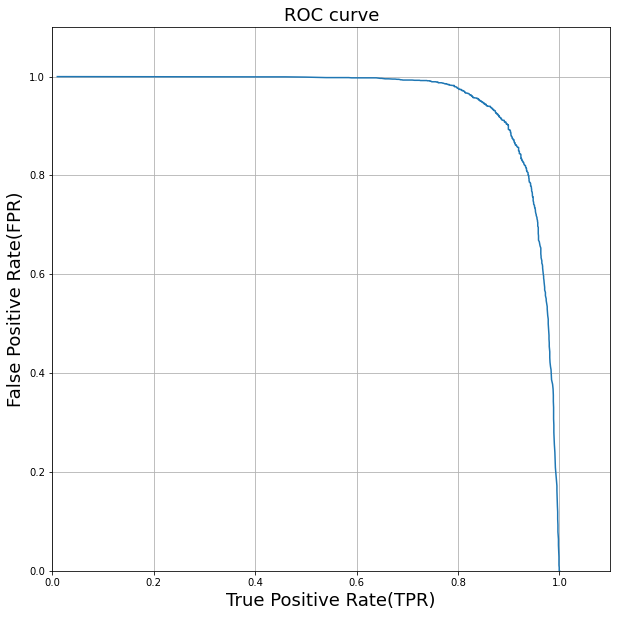

In [31]:
Cnn_tool.sb_histgram(output_y_c3, true_y_c3)
Cnn_tool.plot_roc(output_y_c3, true_y_c3)

In [32]:
x_c3_test.shape
np.save(f"./c3test_result/x{trial_number}", x_c3_test)
np.save(f"./c3test_result/y_output{trial_number}", output_y_c3)
np.save(f"./c3test_result/y_label{trial_number}", true_y_c3)
np.save(f"./c3test_result/event_number{trial_number}", en_c3_test)